In [181]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as mape

In [182]:
FIGSIZE = (20, 6)

location = "A507"
idx = "datetime"
target = "global-radiation"
by_day_rolling = pd.read_csv(f"treated-data/by_day_rolling_{location}.csv")
by_day_rolling.tail()

,datetime,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
7314,2024-07-27,1424.344643,0.0,42.391369,23.010863,21.665179,1.292857,4.282143
7315,2024-07-28,1434.272321,0.0,42.375000,23.020833,21.685863,1.322024,4.353720
7316,2024-07-29,1464.705357,0.0,41.715774,23.093899,21.763095,1.326339,4.347619
7317,2024-07-30,1472.804464,0.0,41.096726,23.187054,21.841667,1.298214,4.280655
7318,2024-07-31,1473.994940,0.0,41.028274,23.220238,21.877083,1.345387,4.379911


In [183]:
by_day_rolling[idx] = by_day_rolling[idx].apply(
    lambda d: pd.to_datetime(d, format="%Y-%m-%d")
)
by_day_rolling = by_day_rolling.set_index(idx)
by_day_rolling.tail()

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
datetime,,,,,,,
2024-07-27,1424.344643,0.0,42.391369,23.010863,21.665179,1.292857,4.282143
2024-07-28,1434.272321,0.0,42.375000,23.020833,21.685863,1.322024,4.353720
2024-07-29,1464.705357,0.0,41.715774,23.093899,21.763095,1.326339,4.347619
2024-07-30,1472.804464,0.0,41.096726,23.187054,21.841667,1.298214,4.280655
2024-07-31,1473.994940,0.0,41.028274,23.220238,21.877083,1.345387,4.379911


(6657, 365)

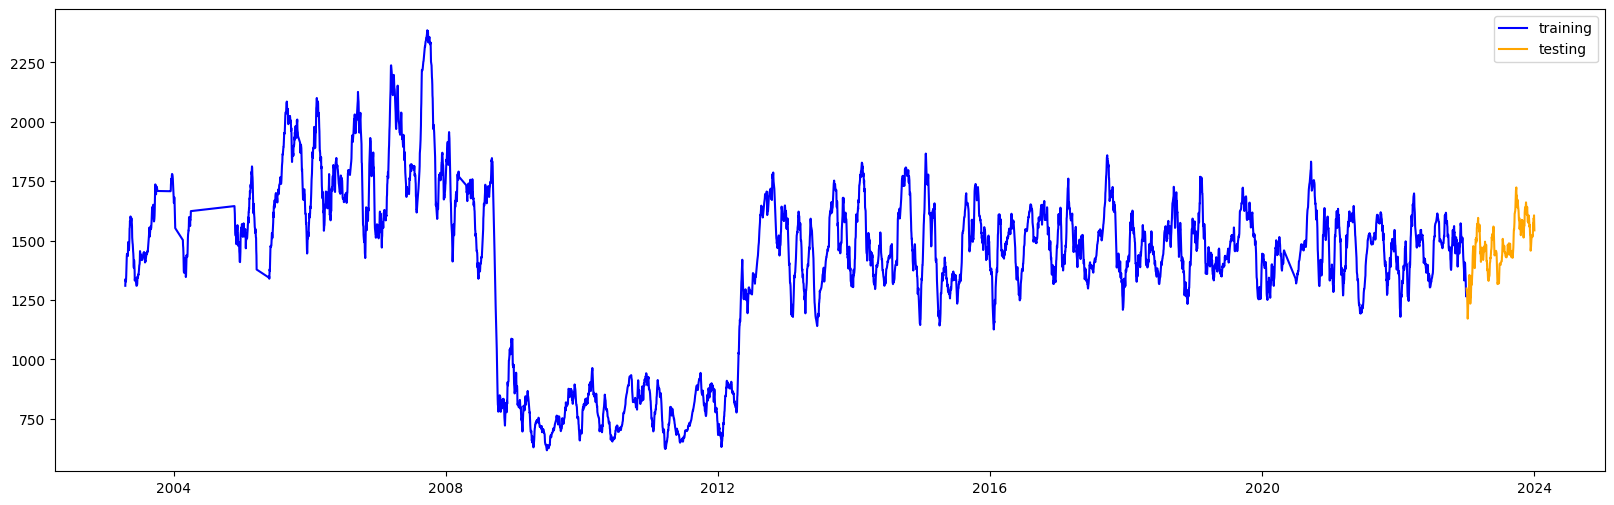

In [184]:
from src.train_test_data import split_datasets

date_threshold = pd.to_datetime("2023-01-01", format="%Y-%m-%d")
date_upper_threshold = date_threshold + pd.DateOffset(years=1)

train_rolling, test_rolling = split_datasets(
    by_day_rolling, date_threshold, date_upper_threshold
)

train_rolling, test_rolling = train_rolling.dropna(), test_rolling.dropna()

plt.figure(figsize=FIGSIZE)
plt.plot(train_rolling[target], color="blue", label="training")
plt.plot(test_rolling[target], color="orange", label="testing")
plt.legend()

len(train_rolling), len(test_rolling)

In [185]:
fit_data = pd.DataFrame(dict(ds=train_rolling.index, y=train_rolling[target]))

reg = Prophet()
reg
reg.fit(fit_data)

12:10:11 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing


In [186]:
prediction_size = test_rolling.size
future = reg.make_future_dataframe(periods=prediction_size)

future.tail()

,ds
9207,2029-12-26
9208,2029-12-27
9209,2029-12-28
9210,2029-12-29
9211,2029-12-30


/home/fellipessanha/solar-studies/venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/fellipessanha/solar-studies/venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


'plotting prophet forecast:'

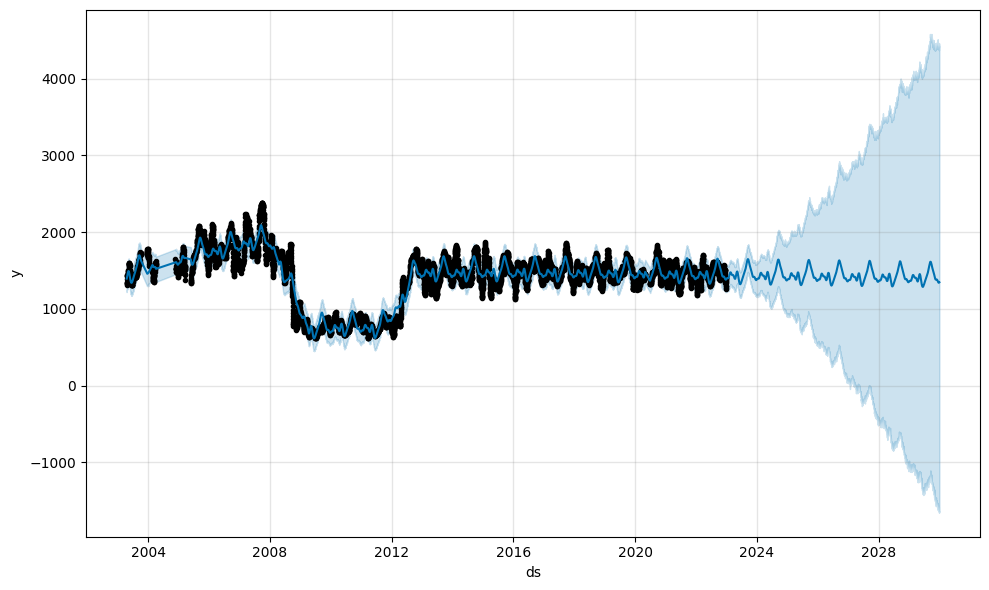

In [187]:
forecast = reg.predict(future)
reg.plot(forecast)
"plotting prophet forecast:"

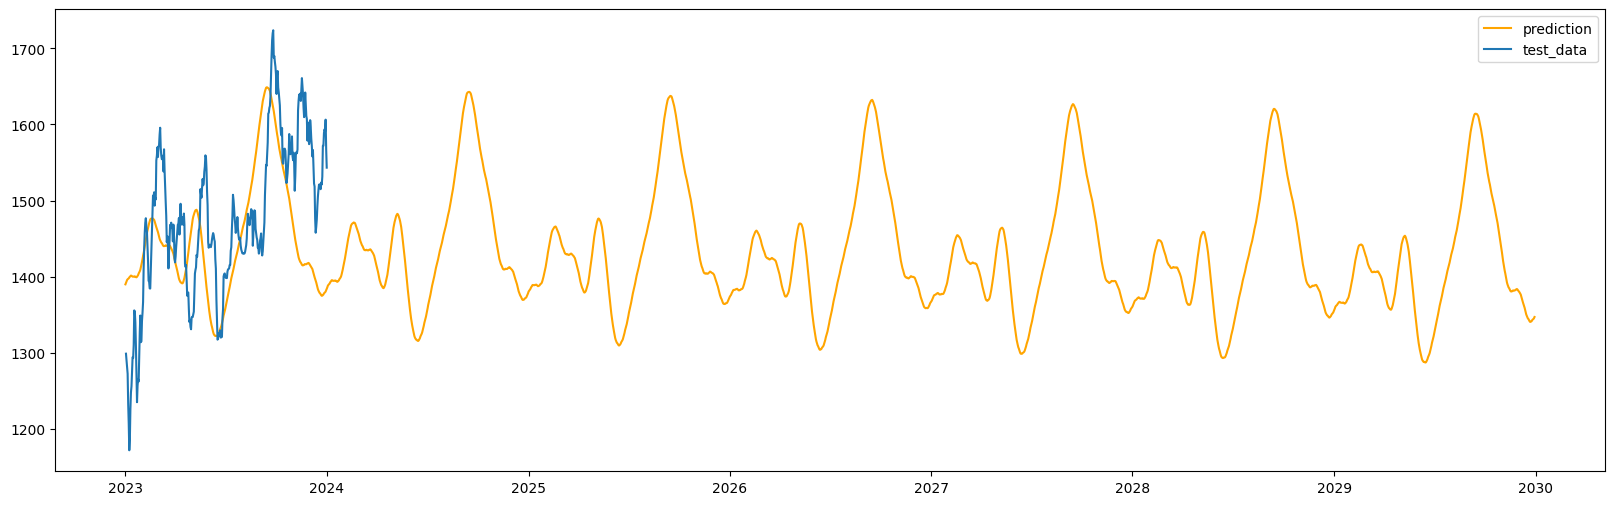

In [188]:
prediction = forecast.loc[forecast.ds >= date_threshold, ["ds", "yhat"]]

plt.figure(figsize=FIGSIZE)
plt.plot(prediction.ds, prediction.yhat, color="orange", label="prediction")
plt.plot(test_rolling[target], label="test_data")
plt.legend()

'predition error is 0.0576%'

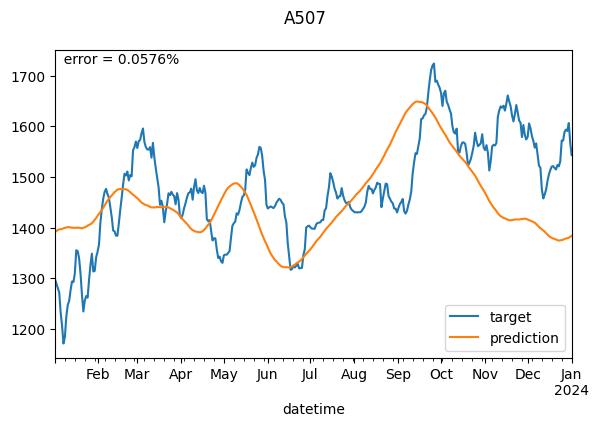

In [189]:
from src.train_test_data import testing_treshold


prediction_renamed = pd.DataFrame({idx: prediction.ds, "yhat": prediction.yhat}).loc[
    testing_treshold(prediction.ds, date_threshold, date_upper_threshold)
]
comparison = test_rolling.merge(prediction_renamed, on=idx)
comparison = comparison.loc[
    (comparison.yhat.notna()) & (comparison[target].notna()), [idx, target, "yhat"]
].set_index(idx)
comparison
error = mape(comparison[target], comparison.yhat)
ax = comparison.rename(columns={target: "target", "yhat": "prediction"}).plot(
    figsize=(FIGSIZE[0] / 3, 4)
)
ax.text(comparison.index.min(), comparison.max(None), f"  error = {error:.4f}%")
plt.suptitle(location)

f"predition error is {error:.4f}%"

In [190]:
from src.forecasting.prophet import ProphetForecaster

fc = ProphetForecaster(
    by_day_rolling, date_threshold, date_upper_threshold, target, idx, mape
)

In [191]:
error = fc.evaluate_model()

12:10:15 - cmdstanpy - INFO - Chain [1] start processing
12:10:18 - cmdstanpy - INFO - Chain [1] done processing


Text(2023-01-02 00:00:00, 1171.636653584511, '  error = 0.0576%')

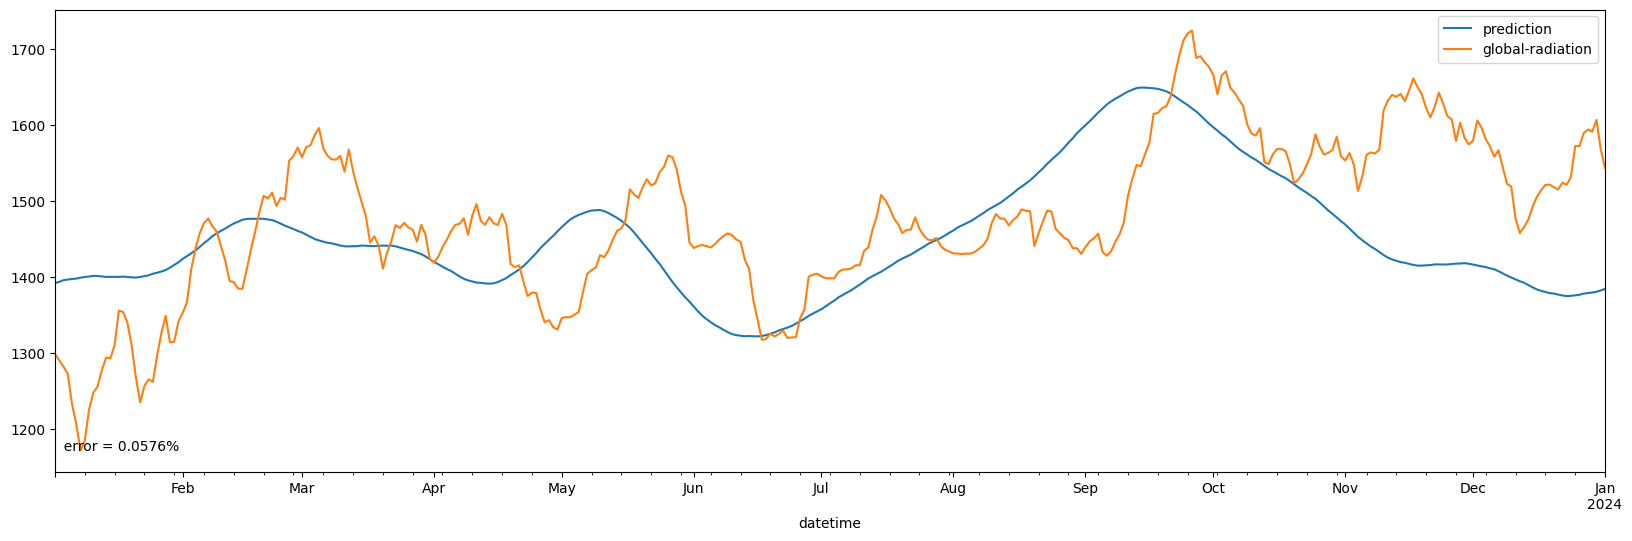

In [192]:
ax = fc.prediction.plot(figsize=FIGSIZE)
ax.text(fc.prediction.index.min(), fc.prediction.min(None), f"  error = {error:.4f}%")